In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2 as cv
from keras.preprocessing import image
import tensorflow


trainPath = '/kaggle/input/gtsrb-german-traffic-sign/Train'

data=[]
labels=[]
dataset_category_count = 0
for dirs in os.listdir(trainPath): #slozky z Train foldery
    #print(dirs)
    for files in os.listdir(trainPath+'/'+ dirs): #obrazek z foldery v kategorii
        try:
            sign_img = np.array(image.load_img(trainPath + "/"+ dirs +"/"+ files, target_size = (32,32)))
            data.append(sign_img) #do seznamu s obrazkovymi daty prida aktualne zpracovany/nacteny obrazek
            labels.append(int(dirs)) #do seznamu s labely prida cislo labelu ve kterem se obrazek nachazi
        except:
            pass
    dataset_category_count += 1
print(str(dataset_category_count))    

43


In [2]:
print(len(data),len(labels))
#popisky obrazku
category_labels = {
    0:"Speed limit (20km/h)",
    1:"Speed limit (30km/h)",
    2:"Speed limit (50km/h)",
    3:"Speed limit (60km/h)",
    4:"Speed limit (70km/h)",
    5:"Speed limit (80km/h)",
    6:"End of speed limit (80km/h)",
    7:"Speed limit (100km/h)",
    8:"Speed limit (120km/h)",
    9:"No passing",
    10:"No passing for vehicles over 3.5 metric tons",
    11:"Right-of-way at the next intersection",
    12:"Priority road",
    13:"Yield",
    14:"Stop",
    15:"No vehicles",
    16:"Vehicles over 3.5 metric tons prohibited",
    17:"No entry",
    18:"General caution",
    19:"Dangerous curve to the left",
    20:"Dangerous curve to the right",
    21:"Double curve",
    22:"Bumpy road",
    23:"Slippery road",
    24:"Road narrows on the right",
    25:"Road work",
    26:"Traffic signals",
    27:"Pedestrians",
    28:"Children crossing",
    29:"Bicycles crossing",
    30:"Beware of ice/snow",
    31:"Wild animals crossing",
    32:"End of all speed and passing limits",
    33:"Turn right ahead",
    34:"Turn left ahead",
    35:"Ahead only",
    36:"Go straight or right",
    37:"Go straight or left",
    38:"Keep right",
    39:"Keep left",
    40:"Roudabout mandatory",
    41:"End of no passing",
    42:"End of no passing by vehicles over 3.5 metric tons",
}
category_labels[0]


39209 39209


'Speed limit (20km/h)'

19437


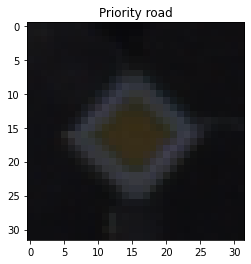

6588


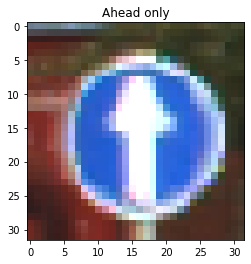

20466


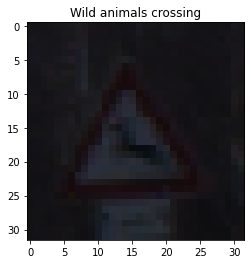

In [3]:
import matplotlib.pyplot as plt
import random

for i in range(3):
    rnd = random.randint(0,len(data))
    print(str(rnd))
    preview = plt.imshow(data[rnd])
    preview_title = plt.title(category_labels[labels[rnd]])
    plt.show()
 

X_train length: 31367
y_train length: 31367
X_test length: 7842
y_test length: 7842


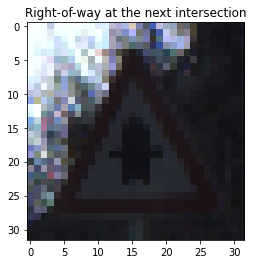

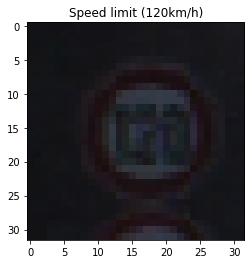

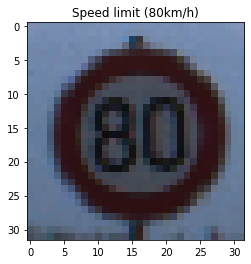

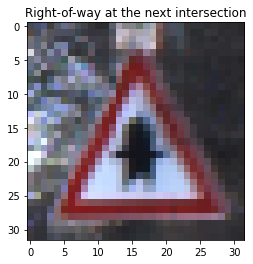

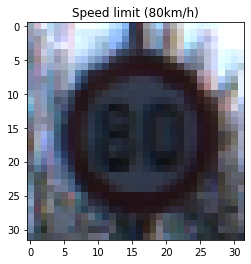

In [4]:
from sklearn.model_selection import train_test_split

#rozrazeni datasetu na trenovaci a testovaci data
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=123)

print('X_train length:', len(X_train))
print('y_train length:', len(y_train))
print('X_test length:', len(X_test))
print('y_test length:', len(y_test))


for i in range(5):
    plt.grid(False)
    plt.imshow(X_train[i])
    plt.title(category_labels[y_train[i]])
    plt.show()